# Analyzing NYPD Historical Crime Data: Impact on academic performance 


## Abstract 

This is a breakdown of every criminal complaint report filed in NYC by the NYPD in 2011. This data is manually extracted every quarter and reviewed by the Office of Management Analysis and Planning. Each record represents a criminal complaint in NYC and includes information abot the type of crime, the location and time of enforcement. This data can be used by the public to explore the nature of criminal activity in conjunction with the Safety/Respect Scores and SAT performance. 

## Methods 

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2017). For additional details, please see the [data dictionary](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i). 

I preprocessed the data and selected only the variables of my interest and saved the file as NYPD_Complaint_Data_Historic_2011.csv.

# ETL

In [1]:
#Libraries used for analysis and visualizations 

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.express as px
import seaborn as sns 
import folium
from folium.plugins import HeatMap
from random import sample 
import branca.colormap as cm
import json


In [2]:
crime_2011 = pd.read_csv('schools/NYPD_Complaint_Data_Historic_PDID.csv', index_col = 'CMPLNT_NUM')
crime_2011.head()

,CMPLNT_FR_DT,OFNS_DESC,PD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,SUSP_RACE,Latitude,Longitude,PATROL_BORO
CMPLNT_NUM,,,,,,,,,,
519234712,1/1/2011,SEX CRIMES,177.0,FELONY,BROOKLYN,INSIDE,WHITE HISPANIC,40.648650,-73.950336,PATROL BORO BKLYN SOUTH
495207193,1/1/2011,PETIT LARCENY,338.0,MISDEMEANOR,MANHATTAN,INSIDE,NaN,40.862255,-73.926297,PATROL BORO MAN NORTH
527650130,1/1/2011,SEX CRIMES,177.0,FELONY,BRONX,INSIDE,UNKNOWN,40.816392,-73.895296,PATROL BORO BRONX
512891731,1/1/2011,FRAUDS,718.0,MISDEMEANOR,BROOKLYN,INSIDE,NaN,40.633193,-73.941884,PATROL BORO BKLYN SOUTH
234370701,1/1/2011,RAPE,157.0,FELONY,QUEENS,NaN,UNKNOWN,40.745253,-73.870063,PATROL BORO QUEENS NORTH


In [3]:
crime_2011.isnull().sum()

CMPLNT_FR_DT              0
OFNS_DESC              1625
PD_CD                   494
LAW_CAT_CD                0
BORO_NM                 499
LOC_OF_OCCUR_DESC    112230
SUSP_RACE            298651
Latitude                 54
Longitude                54
PATROL_BORO             494
dtype: int64

In [4]:
crime_2011.dtypes

CMPLNT_FR_DT          object
OFNS_DESC             object
PD_CD                float64
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
SUSP_RACE             object
Latitude             float64
Longitude            float64
PATROL_BORO           object
dtype: object

In [5]:
# Keeping all rows with Borough Names 
crime_df = crime_2011[crime_2011['SUSP_RACE'].notna()]

crime_df.head()

,CMPLNT_FR_DT,OFNS_DESC,PD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,SUSP_RACE,Latitude,Longitude,PATROL_BORO
CMPLNT_NUM,,,,,,,,,,
519234712,1/1/2011,SEX CRIMES,177.0,FELONY,BROOKLYN,INSIDE,WHITE HISPANIC,40.648650,-73.950336,PATROL BORO BKLYN SOUTH
527650130,1/1/2011,SEX CRIMES,177.0,FELONY,BRONX,INSIDE,UNKNOWN,40.816392,-73.895296,PATROL BORO BRONX
234370701,1/1/2011,RAPE,157.0,FELONY,QUEENS,NaN,UNKNOWN,40.745253,-73.870063,PATROL BORO QUEENS NORTH
109241832,1/1/2011,THEFT-FRAUD,739.0,FELONY,MANHATTAN,INSIDE,UNKNOWN,40.802140,-73.939060,PATROL BORO MAN NORTH
911408185,1/1/2011,SEX CRIMES,177.0,FELONY,MANHATTAN,INSIDE,BLACK HISPANIC,40.736698,-73.983316,PATROL BORO MAN SOUTH


In [6]:
crime_df= crime_df[['CMPLNT_FR_DT', 'OFNS_DESC','PD_CD','LOC_OF_OCCUR_DESC','SUSP_RACE', 'LAW_CAT_CD', 'BORO_NM','Latitude','Longitude', 'PATROL_BORO']]

df_clean =  crime_df[crime_df['Latitude'].notna() & crime_df['Longitude'].notna() & crime_df['OFNS_DESC'] & crime_df['PD_CD'].notna()]
df_clean.isnull().sum()
crime_cleaned = df_clean.rename({'CMPLNT_FR_DT':'Date of Complaint',
                                'OFNS_DESC': 'Offense Desc.',
                                 'LOC_OF_OCCUR_DESC': 'Location of Incident',
                                 'PREM_TYP_DESC': 'Premise Type',
                                 'SUSP_RACE': 'Suspect Race',
                                 'BORO_NM':'Borough',
                                'LAW_CAT_CD':'Crime Classification',
                                'PATROL_BORO': 'Patrol Borough'}, axis =1)

crime_cleaned.head()

,Date of Complaint,Offense Desc.,PD_CD,Location of Incident,Suspect Race,Crime Classification,Borough,Latitude,Longitude,Patrol Borough
CMPLNT_NUM,,,,,,,,,,
519234712,1/1/2011,SEX CRIMES,177.0,INSIDE,WHITE HISPANIC,FELONY,BROOKLYN,40.648650,-73.950336,PATROL BORO BKLYN SOUTH
527650130,1/1/2011,SEX CRIMES,177.0,INSIDE,UNKNOWN,FELONY,BRONX,40.816392,-73.895296,PATROL BORO BRONX
234370701,1/1/2011,RAPE,157.0,NaN,UNKNOWN,FELONY,QUEENS,40.745253,-73.870063,PATROL BORO QUEENS NORTH
109241832,1/1/2011,THEFT-FRAUD,739.0,INSIDE,UNKNOWN,FELONY,MANHATTAN,40.802140,-73.939060,PATROL BORO MAN NORTH
911408185,1/1/2011,SEX CRIMES,177.0,INSIDE,BLACK HISPANIC,FELONY,MANHATTAN,40.736698,-73.983316,PATROL BORO MAN SOUTH


In [7]:
date = crime_cleaned['Date of Complaint'].str.split("/", n=3, expand = True)

crime_cleaned['Day'] = date[1].astype(int)
crime_cleaned['Month'] = date[0].astype(int)


In [8]:
# crime_cleaned['Suspect Race'] = crime_cleaned['Suspect Race'].str.split(" ").apply(lambda x:x[0])
# crime_cleaned.head()

In [9]:
# crime_cleaned.drop(['race'], axis =1 )

In [10]:
crime_cleaned.dtypes

Date of Complaint        object
Offense Desc.            object
PD_CD                   float64
Location of Incident     object
Suspect Race             object
Crime Classification     object
Borough                  object
Latitude                float64
Longitude               float64
Patrol Borough           object
Day                       int32
Month                     int32
dtype: object

In [11]:

months = {1:'Jan', 2:'Feb',3:'Mar',4:'Apr', 5: 'May',6: 'Jun', 7:'Jul', 8: 'Aug',9: 'Sep', 10:'Oct', 11: 'Nov', 12: 'Dec'}
crime_cleaned['Month'] = crime_cleaned['Month'].replace(months)

crime_cleaned.head()

,Date of Complaint,Offense Desc.,PD_CD,Location of Incident,Suspect Race,Crime Classification,Borough,Latitude,Longitude,Patrol Borough,Day,Month
CMPLNT_NUM,,,,,,,,,,,,
519234712,1/1/2011,SEX CRIMES,177.0,INSIDE,WHITE HISPANIC,FELONY,BROOKLYN,40.648650,-73.950336,PATROL BORO BKLYN SOUTH,1,Jan
527650130,1/1/2011,SEX CRIMES,177.0,INSIDE,UNKNOWN,FELONY,BRONX,40.816392,-73.895296,PATROL BORO BRONX,1,Jan
234370701,1/1/2011,RAPE,157.0,NaN,UNKNOWN,FELONY,QUEENS,40.745253,-73.870063,PATROL BORO QUEENS NORTH,1,Jan
109241832,1/1/2011,THEFT-FRAUD,739.0,INSIDE,UNKNOWN,FELONY,MANHATTAN,40.802140,-73.939060,PATROL BORO MAN NORTH,1,Jan
911408185,1/1/2011,SEX CRIMES,177.0,INSIDE,BLACK HISPANIC,FELONY,MANHATTAN,40.736698,-73.983316,PATROL BORO MAN SOUTH,1,Jan


In [12]:
crime_cleaned = crime_cleaned[crime_cleaned['Borough'].notna() & crime_cleaned['Location of Incident'].notna()]

crime_cleaned.isnull().sum()
crime_cleaned.shape

(162808, 12)

# Data Exploration

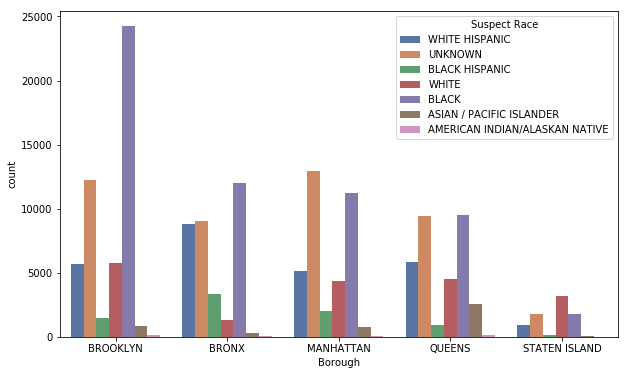

In [13]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = 'Borough', hue  = 'Suspect Race', data=crime_cleaned, palette = 'deep')

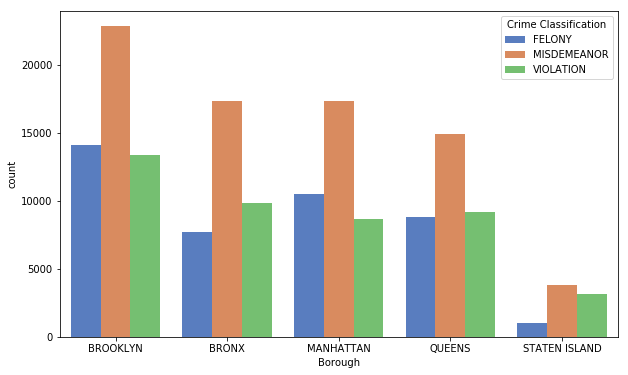

In [14]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = 'Borough', hue  = 'Crime Classification', data=crime_cleaned, palette = 'muted')

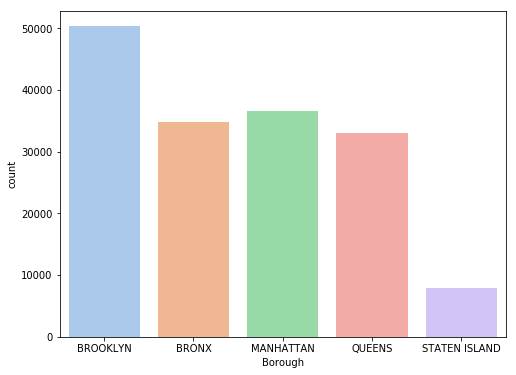

In [15]:
f, ax = plt.subplots(figsize=(8,6))

sns.countplot(x = 'Borough', data=crime_cleaned, palette = 'pastel')

Text(0.5, 1.0, 'Number of Complaints per Month')

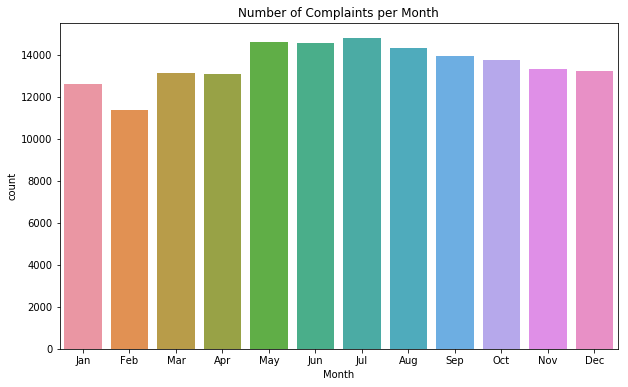

In [16]:
f, ax = plt.subplots(figsize=(10,6))

sns.countplot(x='Month', data =crime_cleaned).set_title('Number of Complaints per Month')




In [17]:
boro = crime_cleaned['PD_CD'].value_counts()


boro.columns = ['Borough', 'count']

In [18]:
crime_cleaned.columns

Index(['Date of Complaint', 'Offense Desc.', 'PD_CD', 'Location of Incident',
       'Suspect Race', 'Crime Classification', 'Borough', 'Latitude',
       'Longitude', 'Patrol Borough', 'Day', 'Month'],
      dtype='object')

In [19]:
# crime_boro = folium.Map(location=[40.75, -73.98],
#                         zoom_start=11,
#                         tiles="CartoDB dark_matter")

# five_boros = a.loc[:,['Suspect Race','Latitude','Longitude','Patrol Borough']]

# for i in range(len(five_boros)):
#     lat = five_boros.iloc[i][1]
#     long = five_boros.iloc[i][2]
#     popup_text = """
#                 Suspect Race: {}<br>
#                 Location Description : {}<br>"""
#     popup_text = popup_text.format(
#                                five_boros.iloc[i][0],
#                                five_boros.iloc[i][3]
#                                )
#     folium.CircleMarker(location = [lat, long], popup= popup_text, fill = True).add_to(crime_boro)
    
# crime_boro.save('race&location.html')

In [20]:
# San Francisco latitude and longitude values
latitude = 40.75
longitude = -73.98
nyc_geo = 'community_districts.geojson'

# Create map
nyc_map = folium.Map(
       location=[latitude,longitude],
       tiles='cartodbpositron',
       zoom_start=12)

# # Use json file  TEST based on class
# nyc_map.choropleth(
#        geo_data=nyc_geo,
#        data=boro,
#        name='choropleth',
#        columns=['Borough','Count'],
#        key_on='feature.properties.BoroName',
#        fill_color='YlOrRd',
#        fill_opacity='0.7',
#        line_opacity='0.2',
#        legend_name='Crime Rate in New York City, by Neighborhood')

# folium.LayerControl().add_to(nyc_map)



choropleth = folium.Choropleth(geo_data = nyc_geo,  
                data = boro,
                columns = ['Borough', 'count'],
                key_on = "feature.properties.BoroCD",
                fill_color = 'YlGn', 
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                legend_name = 'Incidents by Police Department Districts',
                show=False,
                highlight=True).add_to(nyc_map)

print(type(choropleth.geojson))
print(type(choropleth.color_scale))

folium.LayerControl(collapsed=False).add_to(nyc_map)

# Display Region Label
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['BoroCD'], labels=False)
)

# display the map
nyc_map.save('map.html')

<class 'folium.features.GeoJson'>
<class 'branca.colormap.StepColormap'>


In [21]:
positions = []

positions = list(zip(crime_cleaned['Latitude'], crime_cleaned['Longitude']))
tiles = 'OpenStreetMap'

base_map = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles)

pos_sample = sample(positions, 53000)
HeatMap(pos_sample, radius =8).add_to(base_map)


colormap = cm.LinearColormap(colors=['lightblue','green', 'yellow', 'red'])
colormap.caption = 'Number of Crime Incidents'
colormap.add_to(base_map)

base_map.save('crime_heatmap.html')